In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
%matplotlib inline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
os.listdir('./data')

['gender_submission.csv', 'test.csv', 'train.csv']

In [3]:
df_test = pd.read_csv('./data/test.csv')
df_train = pd.read_csv('./data/train.csv')
df_submission = pd.read_csv('./data/gender_submission.csv')

In [4]:
def transform(df,option):
    assert option in ["test","train"] , "Option must be test or train"
    df = df.set_index('PassengerId')
    cond = df.Fare.isnull()
    sub_value = df.Fare.mean()
    df.Fare = np.where(cond, sub_value, df.Fare)
    ticket_p = df.groupby('Ticket', as_index=False).agg({'Name': 'count'}).rename(columns={'Name':'t_count'}).sort_values('t_count', ascending=False)
    df_merge = df.merge(ticket_p, on='Ticket')
    df_merge['Fare_per_person'] = df_merge.Fare/df_merge.t_count
    cond = df_merge.Age.isnull()
    sub_value = df_merge.Age.mean()
    df_merge.Age = np.where(cond, sub_value, df_merge.Age)
    cond = (df_merge.Sex == 'female')
    sub_value = 1
    df_merge.Sex = np.where(cond, sub_value, 0)
    cond = df_merge.Embarked.isnull()
    sub_value = 'S'
    df_merge.Embarked = np.where(cond, 'S', df_merge.Embarked)
    df_merge = df_merge.drop(['Name', 'Ticket', 'Cabin'], axis=1)
    df_merge.isnull().sum()
    ohe = OneHotEncoder()
    X_cat = ohe.fit_transform(df_merge.Embarked.values.reshape(-1,1)).toarray()
    if option=="train":
        X_short = df_merge.drop(['Survived','Embarked'], axis=1).values
    else:
        X_short = df_merge.drop(['Embarked'], axis=1).values
    X = np.hstack([X_cat, X_short])
    return X

In [5]:
X_train_val=transform(df_train, "train")

In [6]:
y_train_val=df_train.Survived.values

In [7]:
X_test=transform(df_test,"test")

In [8]:
help(train_test_split)

Help on function train_test_split in module sklearn.model_selection._split:

train_test_split(*arrays, **options)
    Split arrays or matrices into random train and test subsets
    
    Quick utility that wraps input validation and
    ``next(ShuffleSplit().split(X, y))`` and application to input data
    into a single call for splitting (and optionally subsampling) data in a
    oneliner.
    
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    *arrays : sequence of indexables with same length / shape[0]
        Allowed inputs are lists, numpy arrays, scipy-sparse
        matrices or pandas dataframes.
    
    test_size : float or int, default=None
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split. If int, represents the
        absolute number of test samples. If None, the value is set to the
        complement of the train size. If ``train_size`` is also Non

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

In [10]:
X_train.shape, X_val.shape

((712, 11), (179, 11))

In [11]:
lr=LogisticRegression()
lr.fit(X_train, y_train)
y_pred_val=lr.predict(X_val)
acc_val=accuracy_score(y_val,y_pred_val)
acc_val

C:\Users\gergo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5865921787709497

In [12]:
help(LogisticRegression)

Help on class LogisticRegression in module sklearn.linear_model._logistic:

class LogisticRegression(sklearn.base.BaseEstimator, sklearn.linear_model._base.LinearClassifierMixin, sklearn.linear_model._base.SparseCoefMixin)
 |  LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
 |  
 |  Logistic Regression (aka logit, MaxEnt) classifier.
 |  
 |  In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
 |  scheme if the 'multi_class' option is set to 'ovr', and uses the
 |  cross-entropy loss if the 'multi_class' option is set to 'multinomial'.
 |  (Currently the 'multinomial' option is supported only by the 'lbfgs',
 |  'sag', 'saga' and 'newton-cg' solvers.)
 |  
 |  This class implements regularized logistic regression using the
 |  'liblinear' library, 'newton-cg', 's

In [20]:
C_grid=np.logspace(-4,9,9)
C_grid

array([1.00000000e-04, 4.21696503e-03, 1.77827941e-01, 7.49894209e+00,
       3.16227766e+02, 1.33352143e+04, 5.62341325e+05, 2.37137371e+07,
       1.00000000e+09])

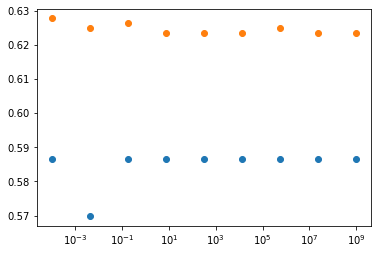

In [21]:
acc_vals=[]
acc_trains=[]
for c in C_grid:
    lr1=LogisticRegression(C=c,max_iter=500)
    lr1.fit(X_train, y_train)
    y_pred_val=lr1.predict(X_val)
    y_pred_train=lr1.predict(X_train)
    acc_train=accuracy_score(y_train,y_pred_train)
    acc_val=accuracy_score(y_val,y_pred_val)
    acc_vals.append(acc_val)
    acc_trains.append(acc_train)
plt.scatter(C_grid,acc_vals)
plt.xscale('log')
plt.scatter(C_grid,acc_trains)
